<a href="https://colab.research.google.com/github/dgiampapa/IEBS/blob/main/4_1_modelos_ML_Score_con_libreria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejecucion de modelos para verificar la puntuacion de cada uno de ellos

# Preprocesamiento

## Preparar el entorno

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.1 MB/s 


In [ ]:
# Se instala la libreria nltk en el caso de que se trabaje de forma local
#!pip install nltk

In [ ]:
# Se instala la libreria datetime que realiza el cambio de la columan de fecha/hora en formato starndard
#!pip install datetime

In [ ]:
# Se importan las librerias que utilizaran en el proyecto

import pandas as pd
import string
import numpy as np

import unidecode
from datetime import datetime

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import nltk

from sklearn.model_selection import train_test_split
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
import os

In [ ]:
# Se importan las librerias de los modelos

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from scipy import stats

import warnings

In [ ]:
# Se realiza la carga de las palabras a utilizar con la libreira nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## lectura de datos 

Este archivo contine el total de tweets que se van a analizar. 

In [ ]:
# Se lee todo el archivo. 
# Se utliza la funcion max_colwidth para colocar el texto completo

ruta = '/content/drive/MyDrive/IEBS/Global Proyect/datos/scoreprueba/score-total.csv'
#ruta = '/content/drive/MyDrive/IEBS/Global Proyect/datos/score/score-total.csv'


pd.set_option('max_colwidth', 800) 
data = pd.read_csv(ruta, index_col=0)
data.head()

,Unnamed: 0.1,Unnamed: 0.1.1,source,text,possibly_sensitive,id,public_metrics,created_at,conversation_id,lang,author_id,geo,neg,neu,pos,score
0,0,0,Twitter for Android,tengan cuidado con estos sms casualmente a mi me va a caducar mi tarjeta y en un descuido podria haber caido en la estafa nunca pinchen enlaces de bancos ni comercios tipo carrefour son falsos https t co qgexvekgu,False,1561410269074624513,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21 17:49:52+00:00,1561410269074624513,es,1129278036086595584,NaN,0.933798,0.064603,0.001600,neg
1,1,1,Twitter for iPhone,la señora es una mas de los desgraciados globalistas y comunistas de la agenda si su padre levantara la cabeza la empalaba en una estaca de avellano hasta que la saliera por la boca adivinad por donde entraria la estaca,False,1561391290482401282,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21 16:34:27+00:00,1561091985296990211,es,471258395,NaN,0.997818,0.001756,0.000427,neg
2,2,2,Twitter for iPhone,culpa tuya por trabajar con ellos,False,1561390305961713665,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21 16:30:32+00:00,1560971603697082369,es,810953027049975809,NaN,0.957792,0.039088,0.003120,neg
3,3,3,Twitter for iPhone,cuidado estafadores haciendose pasar por enviando sms para robarte los datos no sabian que no tengo santander https t co iegbzed,False,1561383588079321088,"{'retweet_count': 0, 'reply_count': 1, 'like_count': 1, 'quote_count': 0}",2022-08-21 16:03:51+00:00,1561383588079321088,es,1296205551962128385,NaN,0.991035,0.008265,0.000700,neg
4,4,4,Metricool,🤝 santander es ofrece cursos para formar a sus empleados en sostenibilidad🟢 rrhh cursos sostenibilidad santander rsc asg https t co jxsbqowmzg,False,1561375377448116229,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}",2022-08-21 15:31:13+00:00,1561375377448116229,es,98842002,NaN,0.013867,0.949543,0.036591,neu


In [ ]:
# Se visualiza la cantidad de datos que contiene 
data.shape

(3390, 16)

In [ ]:
# Se copia el dataframe para realizar la limpieza. No se va a modificar el DF original.
df_cleaning = data.copy(deep=True)

In [ ]:
df_cleaning.dtypes

Unnamed: 0.1            int64
Unnamed: 0.1.1          int64
source                 object
text                   object
possibly_sensitive       bool
id                      int64
public_metrics         object
created_at             object
conversation_id         int64
lang                   object
author_id               int64
geo                    object
neg                   float64
neu                   float64
pos                   float64
score                  object
dtype: object

# Data Cleanning

## Remover duplicados  mover 1

In [ ]:
df_cleaning.drop_duplicates(inplace=True)

In [ ]:
df_cleaning.shape

(3390, 16)

## Revisar y Eliminar Null

In [ ]:
df_cleaning.isna().sum()

Unnamed: 0.1             0
Unnamed: 0.1.1           0
source                   0
text                     0
possibly_sensitive       0
id                       0
public_metrics           0
created_at               0
conversation_id          0
lang                     0
author_id                0
geo                   3303
neg                      0
neu                      0
pos                      0
score                    0
dtype: int64

In [ ]:
# No eliminar los nulos por geo
#df_cleaning.dropna(axis=0, inplace=True)

In [ ]:
df_cleaning.isna().sum()

Unnamed: 0.1             0
Unnamed: 0.1.1           0
source                   0
text                     0
possibly_sensitive       0
id                       0
public_metrics           0
created_at               0
conversation_id          0
lang                     0
author_id                0
geo                   3303
neg                      0
neu                      0
pos                      0
score                    0
dtype: int64

## Eliminar menciones

In [ ]:
# text = "El @MercantilBanco me quito 180.000 Bs por 4 mensajes de texto al 24024 solicitando clave temporal para un pago móvil, la cual nunca llego, son ladrones o no? https://t.co/bVVmvxfhjH"
# text = " ".join(filter(lambda x:x[0:4]!='http', text.split()))
# text

In [ ]:
def remove_link(text):
    text = " ".join(filter(lambda x:x[0:4]!='http', text.split()))
    return text

In [ ]:
# df_cleaning['text'] = df_cleaning['text'].apply(remove_link)
# df_cleaning.head()

In [ ]:
def remove_mencion(text):
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    return text

In [ ]:
df_cleaning['text'] = df_cleaning['text'].apply(remove_mencion)
df_cleaning.head()

,Unnamed: 0.1,Unnamed: 0.1.1,source,text,possibly_sensitive,id,public_metrics,created_at,conversation_id,lang,author_id,geo,neg,neu,pos,score
0,0,0,Twitter for Android,tengan cuidado con estos sms casualmente a mi me va a caducar mi tarjeta y en un descuido podria haber caido en la estafa nunca pinchen enlaces de bancos ni comercios tipo carrefour son falsos https t co qgexvekgu,False,1561410269074624513,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21 17:49:52+00:00,1561410269074624513,es,1129278036086595584,NaN,0.933798,0.064603,0.001600,neg
1,1,1,Twitter for iPhone,la señora es una mas de los desgraciados globalistas y comunistas de la agenda si su padre levantara la cabeza la empalaba en una estaca de avellano hasta que la saliera por la boca adivinad por donde entraria la estaca,False,1561391290482401282,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21 16:34:27+00:00,1561091985296990211,es,471258395,NaN,0.997818,0.001756,0.000427,neg
2,2,2,Twitter for iPhone,culpa tuya por trabajar con ellos,False,1561390305961713665,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21 16:30:32+00:00,1560971603697082369,es,810953027049975809,NaN,0.957792,0.039088,0.003120,neg
3,3,3,Twitter for iPhone,cuidado estafadores haciendose pasar por enviando sms para robarte los datos no sabian que no tengo santander https t co iegbzed,False,1561383588079321088,"{'retweet_count': 0, 'reply_count': 1, 'like_count': 1, 'quote_count': 0}",2022-08-21 16:03:51+00:00,1561383588079321088,es,1296205551962128385,NaN,0.991035,0.008265,0.000700,neg
4,4,4,Metricool,🤝 santander es ofrece cursos para formar a sus empleados en sostenibilidad🟢 rrhh cursos sostenibilidad santander rsc asg https t co jxsbqowmzg,False,1561375377448116229,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}",2022-08-21 15:31:13+00:00,1561375377448116229,es,98842002,NaN,0.013867,0.949543,0.036591,neu


## Formateo de campo fecha

In [ ]:
df_cleaning['created_at'] = pd.to_datetime(df_cleaning['created_at']) #lo hacemos un objeto tiempo
df_cleaning['created_at'] = df_cleaning['created_at'].dt.strftime("%Y-%m-%d") #tomo los elementos que quiero de ese objeto
df_cleaning['created_at'] = pd.to_datetime(df_cleaning['created_at']) #vuelvo a hacerlo un objeto datetime

df_cleaning.head()

,Unnamed: 0.1,Unnamed: 0.1.1,source,text,possibly_sensitive,id,public_metrics,created_at,conversation_id,lang,author_id,geo,neg,neu,pos,score
0,0,0,Twitter for Android,tengan cuidado con estos sms casualmente a mi me va a caducar mi tarjeta y en un descuido podria haber caido en la estafa nunca pinchen enlaces de bancos ni comercios tipo carrefour son falsos https t co qgexvekgu,False,1561410269074624513,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561410269074624513,es,1129278036086595584,NaN,0.933798,0.064603,0.001600,neg
1,1,1,Twitter for iPhone,la señora es una mas de los desgraciados globalistas y comunistas de la agenda si su padre levantara la cabeza la empalaba en una estaca de avellano hasta que la saliera por la boca adivinad por donde entraria la estaca,False,1561391290482401282,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561091985296990211,es,471258395,NaN,0.997818,0.001756,0.000427,neg
2,2,2,Twitter for iPhone,culpa tuya por trabajar con ellos,False,1561390305961713665,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1560971603697082369,es,810953027049975809,NaN,0.957792,0.039088,0.003120,neg
3,3,3,Twitter for iPhone,cuidado estafadores haciendose pasar por enviando sms para robarte los datos no sabian que no tengo santander https t co iegbzed,False,1561383588079321088,"{'retweet_count': 0, 'reply_count': 1, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561383588079321088,es,1296205551962128385,NaN,0.991035,0.008265,0.000700,neg
4,4,4,Metricool,🤝 santander es ofrece cursos para formar a sus empleados en sostenibilidad🟢 rrhh cursos sostenibilidad santander rsc asg https t co jxsbqowmzg,False,1561375377448116229,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561375377448116229,es,98842002,NaN,0.013867,0.949543,0.036591,neu


## Elimina los caracteres iniciales (espacios al principio) y finales (espacios al final)

In [ ]:
df_cleaning['text'] = df_cleaning['text'].str.strip()
df_cleaning.head()

,Unnamed: 0.1,Unnamed: 0.1.1,source,text,possibly_sensitive,id,public_metrics,created_at,conversation_id,lang,author_id,geo,neg,neu,pos,score
0,0,0,Twitter for Android,tengan cuidado con estos sms casualmente a mi me va a caducar mi tarjeta y en un descuido podria haber caido en la estafa nunca pinchen enlaces de bancos ni comercios tipo carrefour son falsos https t co qgexvekgu,False,1561410269074624513,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561410269074624513,es,1129278036086595584,NaN,0.933798,0.064603,0.001600,neg
1,1,1,Twitter for iPhone,la señora es una mas de los desgraciados globalistas y comunistas de la agenda si su padre levantara la cabeza la empalaba en una estaca de avellano hasta que la saliera por la boca adivinad por donde entraria la estaca,False,1561391290482401282,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561091985296990211,es,471258395,NaN,0.997818,0.001756,0.000427,neg
2,2,2,Twitter for iPhone,culpa tuya por trabajar con ellos,False,1561390305961713665,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1560971603697082369,es,810953027049975809,NaN,0.957792,0.039088,0.003120,neg
3,3,3,Twitter for iPhone,cuidado estafadores haciendose pasar por enviando sms para robarte los datos no sabian que no tengo santander https t co iegbzed,False,1561383588079321088,"{'retweet_count': 0, 'reply_count': 1, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561383588079321088,es,1296205551962128385,NaN,0.991035,0.008265,0.000700,neg
4,4,4,Metricool,🤝 santander es ofrece cursos para formar a sus empleados en sostenibilidad🟢 rrhh cursos sostenibilidad santander rsc asg https t co jxsbqowmzg,False,1561375377448116229,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561375377448116229,es,98842002,NaN,0.013867,0.949543,0.036591,neu


## Se Eliminan los Caracteres Especiales

👇 Remove punctuation and lower case the text.

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
mi_puntuacion = '!¡"#$%&\'()*+,-./:;<=>¿?@[\\]^_`{|}~'

In [ ]:
def remove_puntuation(text):
    for punctuation in mi_puntuacion:
        text = text.replace(punctuation, " ")
    return text

In [ ]:
df_cleaning['text'] = df_cleaning['text'].apply(remove_puntuation)
df_cleaning.head()

,Unnamed: 0.1,Unnamed: 0.1.1,source,text,possibly_sensitive,id,public_metrics,created_at,conversation_id,lang,author_id,geo,neg,neu,pos,score
0,0,0,Twitter for Android,tengan cuidado con estos sms casualmente a mi me va a caducar mi tarjeta y en un descuido podria haber caido en la estafa nunca pinchen enlaces de bancos ni comercios tipo carrefour son falsos https t co qgexvekgu,False,1561410269074624513,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561410269074624513,es,1129278036086595584,NaN,0.933798,0.064603,0.001600,neg
1,1,1,Twitter for iPhone,la señora es una mas de los desgraciados globalistas y comunistas de la agenda si su padre levantara la cabeza la empalaba en una estaca de avellano hasta que la saliera por la boca adivinad por donde entraria la estaca,False,1561391290482401282,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561091985296990211,es,471258395,NaN,0.997818,0.001756,0.000427,neg
2,2,2,Twitter for iPhone,culpa tuya por trabajar con ellos,False,1561390305961713665,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1560971603697082369,es,810953027049975809,NaN,0.957792,0.039088,0.003120,neg
3,3,3,Twitter for iPhone,cuidado estafadores haciendose pasar por enviando sms para robarte los datos no sabian que no tengo santander https t co iegbzed,False,1561383588079321088,"{'retweet_count': 0, 'reply_count': 1, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561383588079321088,es,1296205551962128385,NaN,0.991035,0.008265,0.000700,neg
4,4,4,Metricool,🤝 santander es ofrece cursos para formar a sus empleados en sostenibilidad🟢 rrhh cursos sostenibilidad santander rsc asg https t co jxsbqowmzg,False,1561375377448116229,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561375377448116229,es,98842002,NaN,0.013867,0.949543,0.036591,neu


## Covierte en minusculas todo

In [ ]:
def remove_lower(text1):
    text1 = text1.lower()
    return text1

In [ ]:
df_cleaning['text'] = df_cleaning['text'].apply(remove_lower)
df_cleaning.head()

,Unnamed: 0.1,Unnamed: 0.1.1,source,text,possibly_sensitive,id,public_metrics,created_at,conversation_id,lang,author_id,geo,neg,neu,pos,score
0,0,0,Twitter for Android,tengan cuidado con estos sms casualmente a mi me va a caducar mi tarjeta y en un descuido podria haber caido en la estafa nunca pinchen enlaces de bancos ni comercios tipo carrefour son falsos https t co qgexvekgu,False,1561410269074624513,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561410269074624513,es,1129278036086595584,NaN,0.933798,0.064603,0.001600,neg
1,1,1,Twitter for iPhone,la señora es una mas de los desgraciados globalistas y comunistas de la agenda si su padre levantara la cabeza la empalaba en una estaca de avellano hasta que la saliera por la boca adivinad por donde entraria la estaca,False,1561391290482401282,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561091985296990211,es,471258395,NaN,0.997818,0.001756,0.000427,neg
2,2,2,Twitter for iPhone,culpa tuya por trabajar con ellos,False,1561390305961713665,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1560971603697082369,es,810953027049975809,NaN,0.957792,0.039088,0.003120,neg
3,3,3,Twitter for iPhone,cuidado estafadores haciendose pasar por enviando sms para robarte los datos no sabian que no tengo santander https t co iegbzed,False,1561383588079321088,"{'retweet_count': 0, 'reply_count': 1, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561383588079321088,es,1296205551962128385,NaN,0.991035,0.008265,0.000700,neg
4,4,4,Metricool,🤝 santander es ofrece cursos para formar a sus empleados en sostenibilidad🟢 rrhh cursos sostenibilidad santander rsc asg https t co jxsbqowmzg,False,1561375377448116229,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561375377448116229,es,98842002,NaN,0.013867,0.949543,0.036591,neu


## Elimina Acentos

In [ ]:
from unicodedata import normalize
def cambia_acentuadas(text):
    trans_tab = dict.fromkeys(map(ord, u'\u0301\u0308'), None)
    text = normalize('NFKC', normalize('NFKD', text).translate(trans_tab))
    return text

In [ ]:
df_cleaning['text'] = df_cleaning['text'].apply(cambia_acentuadas)
df_cleaning.head()

,Unnamed: 0.1,Unnamed: 0.1.1,source,text,possibly_sensitive,id,public_metrics,created_at,conversation_id,lang,author_id,geo,neg,neu,pos,score
0,0,0,Twitter for Android,tengan cuidado con estos sms casualmente a mi me va a caducar mi tarjeta y en un descuido podria haber caido en la estafa nunca pinchen enlaces de bancos ni comercios tipo carrefour son falsos https t co qgexvekgu,False,1561410269074624513,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561410269074624513,es,1129278036086595584,NaN,0.933798,0.064603,0.001600,neg
1,1,1,Twitter for iPhone,la señora es una mas de los desgraciados globalistas y comunistas de la agenda si su padre levantara la cabeza la empalaba en una estaca de avellano hasta que la saliera por la boca adivinad por donde entraria la estaca,False,1561391290482401282,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561091985296990211,es,471258395,NaN,0.997818,0.001756,0.000427,neg
2,2,2,Twitter for iPhone,culpa tuya por trabajar con ellos,False,1561390305961713665,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1560971603697082369,es,810953027049975809,NaN,0.957792,0.039088,0.003120,neg
3,3,3,Twitter for iPhone,cuidado estafadores haciendose pasar por enviando sms para robarte los datos no sabian que no tengo santander https t co iegbzed,False,1561383588079321088,"{'retweet_count': 0, 'reply_count': 1, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561383588079321088,es,1296205551962128385,NaN,0.991035,0.008265,0.000700,neg
4,4,4,Metricool,🤝 santander es ofrece cursos para formar a sus empleados en sostenibilidad🟢 rrhh cursos sostenibilidad santander rsc asg https t co jxsbqowmzg,False,1561375377448116229,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561375377448116229,es,98842002,NaN,0.013867,0.949543,0.036591,neu


## Remueve Numeros

In [ ]:
def remove_numbers(text1):
    text1 = ''.join(word for word in text1 if not word.isdigit())
    return text1

In [ ]:
df_cleaning['text'] = df_cleaning['text'].apply(remove_numbers)
df_cleaning.head()

,Unnamed: 0.1,Unnamed: 0.1.1,source,text,possibly_sensitive,id,public_metrics,created_at,conversation_id,lang,author_id,geo,neg,neu,pos,score
0,0,0,Twitter for Android,tengan cuidado con estos sms casualmente a mi me va a caducar mi tarjeta y en un descuido podria haber caido en la estafa nunca pinchen enlaces de bancos ni comercios tipo carrefour son falsos https t co qgexvekgu,False,1561410269074624513,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561410269074624513,es,1129278036086595584,NaN,0.933798,0.064603,0.001600,neg
1,1,1,Twitter for iPhone,la señora es una mas de los desgraciados globalistas y comunistas de la agenda si su padre levantara la cabeza la empalaba en una estaca de avellano hasta que la saliera por la boca adivinad por donde entraria la estaca,False,1561391290482401282,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561091985296990211,es,471258395,NaN,0.997818,0.001756,0.000427,neg
2,2,2,Twitter for iPhone,culpa tuya por trabajar con ellos,False,1561390305961713665,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1560971603697082369,es,810953027049975809,NaN,0.957792,0.039088,0.003120,neg
3,3,3,Twitter for iPhone,cuidado estafadores haciendose pasar por enviando sms para robarte los datos no sabian que no tengo santander https t co iegbzed,False,1561383588079321088,"{'retweet_count': 0, 'reply_count': 1, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561383588079321088,es,1296205551962128385,NaN,0.991035,0.008265,0.000700,neg
4,4,4,Metricool,🤝 santander es ofrece cursos para formar a sus empleados en sostenibilidad🟢 rrhh cursos sostenibilidad santander rsc asg https t co jxsbqowmzg,False,1561375377448116229,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561375377448116229,es,98842002,NaN,0.013867,0.949543,0.036591,neu


## Separar palabras

In [ ]:
def remove_StopWords(text):
    spanish_stopwords = set(stopwords.words('spanish'))
    #stop_words = set(stopwords.words('spanish'))
    word_tokens = word_tokenize(text) 
    text = [w for w in word_tokens if not w in spanish_stopwords]
    return text

In [ ]:
df_cleaning['text'] = df_cleaning['text'].apply(remove_StopWords)
df_cleaning.head()

,Unnamed: 0.1,Unnamed: 0.1.1,source,text,possibly_sensitive,id,public_metrics,created_at,conversation_id,lang,author_id,geo,neg,neu,pos,score
0,0,0,Twitter for Android,"[cuidado, sms, casualmente, va, caducar, tarjeta, descuido, podria, haber, caido, estafa, nunca, pinchen, enlaces, bancos, comercios, tipo, carrefour, falsos, https, t, co, qgexvekgu]",False,1561410269074624513,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561410269074624513,es,1129278036086595584,NaN,0.933798,0.064603,0.001600,neg
1,1,1,Twitter for iPhone,"[señora, mas, desgraciados, globalistas, comunistas, agenda, si, padre, levantara, cabeza, empalaba, estaca, avellano, saliera, boca, adivinad, entraria, estaca]",False,1561391290482401282,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561091985296990211,es,471258395,NaN,0.997818,0.001756,0.000427,neg
2,2,2,Twitter for iPhone,"[culpa, trabajar]",False,1561390305961713665,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1560971603697082369,es,810953027049975809,NaN,0.957792,0.039088,0.003120,neg
3,3,3,Twitter for iPhone,"[cuidado, estafadores, haciendose, pasar, enviando, sms, robarte, datos, sabian, santander, https, t, co, iegbzed]",False,1561383588079321088,"{'retweet_count': 0, 'reply_count': 1, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561383588079321088,es,1296205551962128385,NaN,0.991035,0.008265,0.000700,neg
4,4,4,Metricool,"[🤝, santander, ofrece, cursos, formar, empleados, sostenibilidad🟢, rrhh, cursos, sostenibilidad, santander, rsc, asg, https, t, co, jxsbqowmzg]",False,1561375377448116229,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561375377448116229,es,98842002,NaN,0.013867,0.949543,0.036591,neu


## Lemmatizer

In [ ]:
from nltk.stem import WordNetLemmatizer
def remove_Lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in text]
    str_lemmatizer = " ".join(lemmatized)
    return str_lemmatizer

In [ ]:
df_cleaning['text'] = df_cleaning['text'].apply(remove_Lemmatize)
df_cleaning.head()

,Unnamed: 0.1,Unnamed: 0.1.1,source,text,possibly_sensitive,id,public_metrics,created_at,conversation_id,lang,author_id,geo,neg,neu,pos,score
0,0,0,Twitter for Android,cuidado sm casualmente va caducar tarjeta descuido podria haber caido estafa nunca pinchen enlaces bancos comercios tipo carrefour falsos http t co qgexvekgu,False,1561410269074624513,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561410269074624513,es,1129278036086595584,NaN,0.933798,0.064603,0.001600,neg
1,1,1,Twitter for iPhone,señora ma desgraciados globalistas comunistas agenda si padre levantara cabeza empalaba estaca avellano saliera boca adivinad entraria estaca,False,1561391290482401282,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1561091985296990211,es,471258395,NaN,0.997818,0.001756,0.000427,neg
2,2,2,Twitter for iPhone,culpa trabajar,False,1561390305961713665,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}",2022-08-21,1560971603697082369,es,810953027049975809,NaN,0.957792,0.039088,0.003120,neg
3,3,3,Twitter for iPhone,cuidado estafadores haciendose pasar enviando sm robarte datos sabian santander http t co iegbzed,False,1561383588079321088,"{'retweet_count': 0, 'reply_count': 1, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561383588079321088,es,1296205551962128385,NaN,0.991035,0.008265,0.000700,neg
4,4,4,Metricool,🤝 santander ofrece cursos formar empleados sostenibilidad🟢 rrhh cursos sostenibilidad santander rsc asg http t co jxsbqowmzg,False,1561375377448116229,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}",2022-08-21,1561375377448116229,es,98842002,NaN,0.013867,0.949543,0.036591,neu


In [ ]:
df_cleaning['text']

0      cuidado sm casualmente va caducar tarjeta descuido podria haber caido estafa nunca pinchen enlaces bancos comercios tipo carrefour falsos http t co qgexvekgu
1                      señora ma desgraciados globalistas comunistas agenda si padre levantara cabeza empalaba estaca avellano saliera boca adivinad entraria estaca
2                                                                                                                                                     culpa trabajar
3                                                                  cuidado estafadores haciendose pasar enviando sm robarte datos sabian santander http t co iegbzed
4                                       🤝 santander ofrece cursos formar empleados sostenibilidad🟢 rrhh cursos sostenibilidad santander rsc asg http t co jxsbqowmzg
                                                                                   ...                                                                              
691       

# Visualizacion

In [ ]:
df_cleaning.shape

(3390, 16)

In [ ]:
# check the number of positive vs. negative tagged sentences
positives = data['score'][data.score=='pos']
negatives = data['score'][data.score == 'neg' ]
neutral =data['score'][data.score == 'neu' ]

print('Total de datos:         {}'.format(data.shape[0]))
print('Numero de positivos:    {}'.format(len(positives)))
print('Numero de negativos:    {}'.format(len(negatives)))
print('Numero de neutros:      {}'.format(len(neutral)))

Total de datos:         3390
Numero de positivos:    191
Numero de negativos:    1630
Numero de neutros:      1569


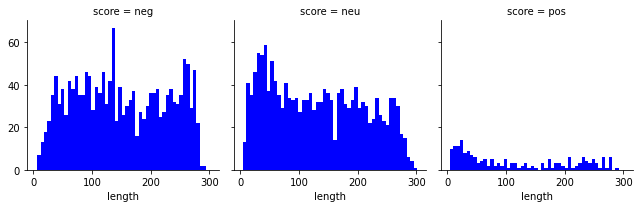

In [ ]:
data.describe(include='all')
data['length'] = data['text'].apply(len)

graph = sns.FacetGrid(data=data,col='score')
graph.map(plt.hist,'length',bins=50,color='blue')

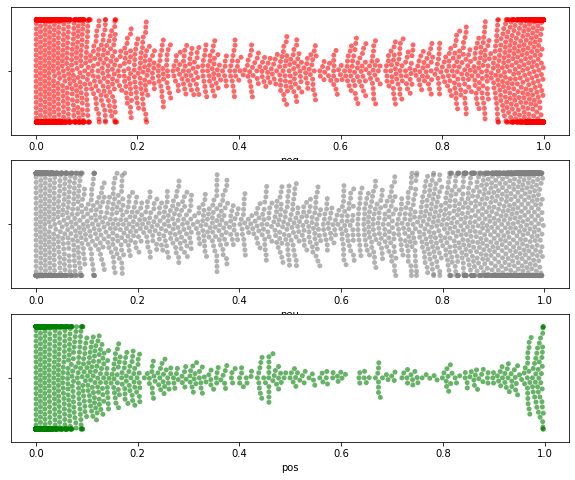

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8))

sns.swarmplot(data.neg , ax = ax[0], color = 'red', alpha = 0.6)
sns.swarmplot(data.neu , ax = ax[1], color = 'grey', alpha = 0.6)
sns.swarmplot(data.pos , ax = ax[2], color = 'green', alpha = 0.6)

In [ ]:
# Contar las palabras por texto
def word_count(words):
    return len(words.split())

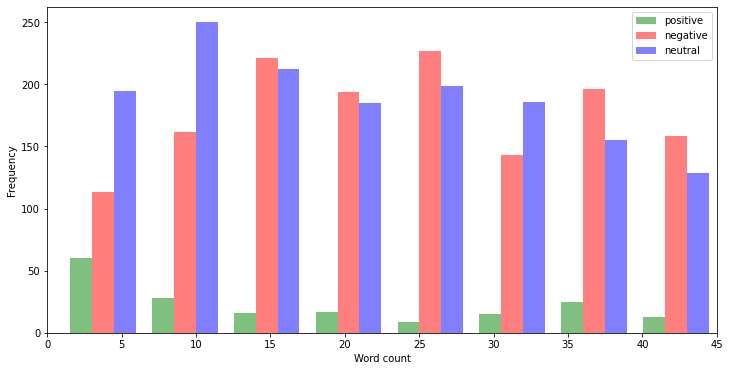

In [ ]:
# plot word count distribution for both positive and negative 

data['word count'] = data['text'].apply(word_count)
pos = data['word count'][data.score == 'pos']
neg = data['word count'][data.score == 'neg']
neu = data['word count'][data.score == 'neu']
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([pos, neg, neu], color=['g','r','b'], alpha=0.5, label=['positive','negative','neutral'])
plt.legend(loc='upper right')

In [ ]:
# get common words in training dataset
from collections import Counter
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(20)

[('que', 2654),
 ('https', 1278),
 ('por', 910),
 ('con', 834),
 ('los', 811),
 ('para', 768),
 ('una', 698),
 ('las', 616),
 ('del', 565),
 ('mas', 416),
 ('como', 358),
 ('banco', 332),
 ('cuenta', 322),
 ('esta', 274),
 ('gracias', 242),
 ('este', 233),
 ('pero', 233),
 ('nos', 208),
 ('sin', 198),
 ('cliente', 178)]

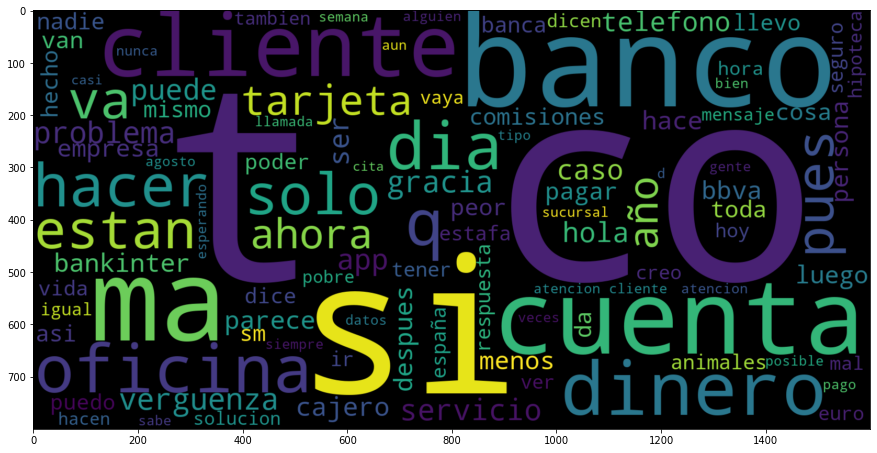

In [ ]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(df_cleaning[df_cleaning.score == 'neg'].text))
plt.imshow(wc , interpolation = 'bilinear')

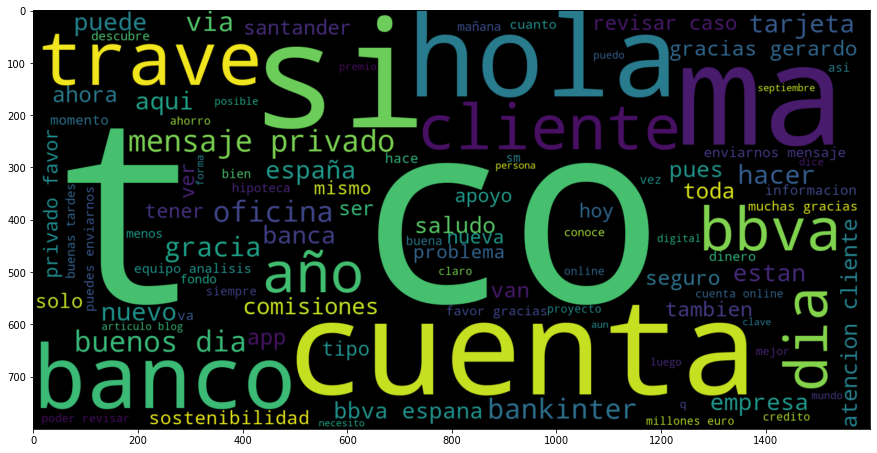

In [ ]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(df_cleaning[df_cleaning.score == 'neu'].text))
plt.imshow(wc , interpolation = 'bilinear')

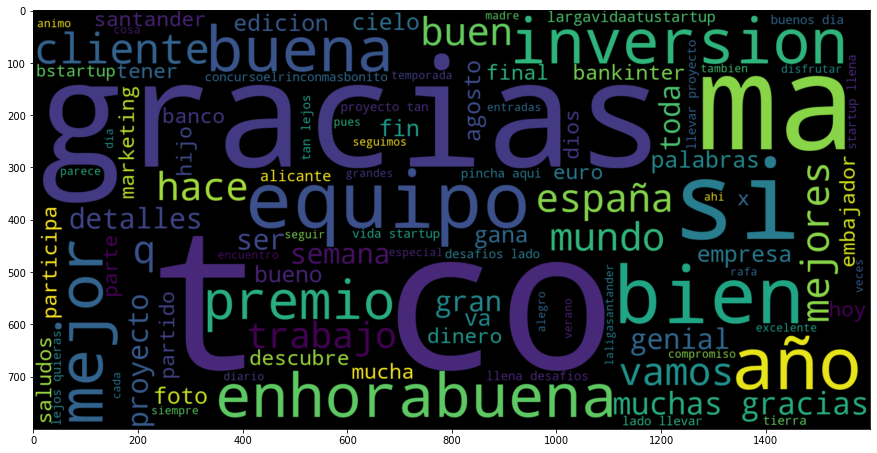

In [ ]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(df_cleaning[df_cleaning.score == 'pos'].text))
plt.imshow(wc , interpolation = 'bilinear')

# Funcion de evaluacion del modelo

In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['neg','neu','pos']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Definir Train y test

In [ ]:
X = df_cleaning['text']
y = df_cleaning['score']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Ejecucion de modelos

## Pipeline modelo MultinomialNB

In [ ]:
# Create Pipeline
warnings.filterwarnings('ignore')

token = RegexpTokenizer(r'[a-zA-Z0-9]+')

# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('model', MultinomialNB()),
])

parameters_MNB = {
    'tfidf__ngram_range': [(1,1), (2,2), (1,2),],
    'tfidf__min_df': stats.loguniform(0.01, 0.2),
    'tfidf__max_df': stats.loguniform(0.01, 0.3),
    'tfidf__norm' : ['l1', 'l2'] ,
    'model__alpha': stats.uniform(0.5, 1)
}

# Perform grid search on pipeline
grid_search_MultinomialNB = RandomizedSearchCV(pipeline, parameters_MNB, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", cv=5, n_iter=800, refit=True)

grid_search_MultinomialNB.fit(X_train,y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(lowercase=False)),
                                             ('model', MultinomialNB())]),
                   n_iter=800, n_jobs=-1,
                   param_distributions={'model__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f42dc8f3f50>,
                                        'tfidf__max_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f42dc8f3d50>,
                                        'tfidf__min_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f42dc8f3950>,
                                        'tfidf__ngram_range': [(1, 1), (2, 2),
                                                               (1, 2)],
                                        'tfidf__norm': ['l1', 'l2']},
                   scoring='accuracy', verbose=1)

In [ ]:
result = grid_search_MultinomialNB.best_estimator_.predict(X_test)
result_df = pd.DataFrame(result)
grid_search_MultinomialNB.cv_results_
# Se graba el modelo para ser utilizado
joblib.dump(grid_search_MultinomialNB.best_estimator_, '/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_MultinomialNB.joblib')

['/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_MultinomialNB.joblib']

## Pipeline modelo Logistic Regression

In [ ]:
# Create Pipeline
warnings.filterwarnings('ignore')

# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('logistic_Reg', LogisticRegression()),
])

parameters_LogisticRegression={
    "logistic_Reg__C":np.logspace(-3,3,7), 
    "logistic_Reg__penalty":["l1","l2"]
    }

# Perform grid search on pipeline
grid_search_LogisticRegression = RandomizedSearchCV(pipeline, parameters_LogisticRegression, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", cv=5, n_iter=800, refit=True)

grid_search_LogisticRegression.fit(X_train,y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(lowercase=False)),
                                             ('logistic_Reg',
                                              LogisticRegression())]),
                   n_iter=800, n_jobs=-1,
                   param_distributions={'logistic_Reg__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'logistic_Reg__penalty': ['l1', 'l2'],
                                        'tfidf__max_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f42dc6a20d0>,
                                        'tfidf__min_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f42dc732cd0>,
                                        'tfidf__ngram_range': [(1, 1), (2, 2),
                                                               (1, 2)],
                                        'tfidf__norm

In [ ]:
result = grid_search_LogisticRegression.best_estimator_.predict(X_test)
result_df = pd.DataFrame(result)
grid_search_LogisticRegression.cv_results_
# Se graba el modelo para ser utilizado
joblib.dump(grid_search_LogisticRegression.best_estimator_, '/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_LogisticRegression.joblib')

['/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_LogisticRegression.joblib']

## Pipeline modelo Linear SVM

In [ ]:
# Create Pipeline
warnings.filterwarnings('ignore')

# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('SVC', LinearSVC()),
])

param_grid_SVC = {
    'SVC__C':np.arange(0.01,100,10)
}

# Perform grid search on pipeline
grid_search_LinearSVC = RandomizedSearchCV(pipeline, param_grid_SVC, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", cv=5, n_iter=800, refit=True)

grid_search_LinearSVC.fit(X_train,y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(lowercase=False)),
                                             ('SVC', LinearSVC())]),
                   n_iter=800, n_jobs=-1,
                   param_distributions={'SVC__C': array([1.000e-02, 1.001e+01, 2.001e+01, 3.001e+01, 4.001e+01, 5.001e+01,
       6.001e+01, 7.001e+01, 8.001e+01, 9.001e+01]),
                                        'tfidf__max_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f42dc720450>,
                                        'tfidf__min_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f42dd1c6610>,
                                        'tfidf__ngram_range': [(1, 1), (2, 2),
                                                               (1, 2)],
                                        'tfidf__norm': ['l1', 'l2']},
                   scoring='accuracy', verbose=1)

In [ ]:
result = grid_search_LinearSVC.best_estimator_.predict(X_test)
result_df = pd.DataFrame(result)
grid_search_LinearSVC.cv_results_
# Se graba el modelo para ser utilizado
joblib.dump(grid_search_LinearSVC.best_estimator_, '/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_LinearSVC.joblib')

['/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_LinearSVC.joblib']

## Pipeline modelo Random Forest

In [ ]:
# Create Pipeline
warnings.filterwarnings('ignore')

# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('Random', RandomForestClassifier()),
])

parameters_Random = { 
    'Random__n_estimators': [200, 500],
    'Random__max_features': ['auto', 'sqrt', 'log2'],
    'Random__max_depth' : [4,5,6,7,8],
    'Random__criterion' :['gini', 'entropy']
}

# Perform grid search on pipeline
grid_search_RandomForestClassifier = RandomizedSearchCV(pipeline, parameters_Random, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", cv=5, n_iter=800, refit=True)

grid_search_RandomForestClassifier.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(lowercase=False)),
                                             ('Random',
                                              RandomForestClassifier())]),
                   n_iter=800, n_jobs=-1,
                   param_distributions={'Random__criterion': ['gini',
                                                              'entropy'],
                                        'Random__max_depth': [4, 5, 6, 7, 8],
                                        'Random__max_features': ['auto', 'sqrt',
                                                                 'log2'],
                                        'Random__n_estimators': [200, 500]},
                   scoring='accuracy', verbose=1)

In [ ]:
result = grid_search_RandomForestClassifier.best_estimator_.predict(X_test)
result_df = pd.DataFrame(result)
grid_search_RandomForestClassifier.cv_results_
# Se graba el modelo para ser utilizado
joblib.dump(grid_search_RandomForestClassifier.best_estimator_, '/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_RandomForestClassifier.joblib')

['/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_RandomForestClassifier.joblib']

## Pipeline modelo Naive Bayes

In [ ]:
# Create Pipeline
warnings.filterwarnings('ignore')

# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('BNB', BernoulliNB()),
])

parameters_BNB = {
    'BNB__alpha': stats.uniform(0.5, 1)
}

# Perform grid search on pipeline
grid_search_BernoulliNB = RandomizedSearchCV(pipeline, parameters_BNB, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", cv=5, n_iter=800, refit=True)

grid_search_BernoulliNB.fit(X_train,y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(lowercase=False)),
                                             ('BNB', BernoulliNB())]),
                   n_iter=800, n_jobs=-1,
                   param_distributions={'BNB__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f42df12a710>},
                   scoring='accuracy', verbose=1)

In [ ]:
result = grid_search_BernoulliNB.best_estimator_.predict(X_test)
result_df = pd.DataFrame(result)
grid_search_BernoulliNB.cv_results_
# Se graba el modelo para ser utilizado
joblib.dump(grid_search_BernoulliNB.best_estimator_, '/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_BernoulliNB.joblib')

['/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_BernoulliNB.joblib']

## Pipeline modelo DecisionTree

In [ ]:
# Create Pipeline
warnings.filterwarnings('ignore')

# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase = False)),
    ('DTC', DecisionTreeClassifier()),
])

parameters_DTC = {
    'DTC__splitter':['best','random'],
    'DTC__max_depth' : [4,5,6,7,8],
    'DTC__criterion' :['gini', 'entropy'],
    'DTC__min_samples_split' : range(1,30),
    'DTC__min_samples_leaf' : range(1,30)
}

# Perform grid search on pipeline
grid_search_DecisionTreeClassifier = RandomizedSearchCV(pipeline, parameters_DTC, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", cv=5, n_iter=800, refit=True)

grid_search_DecisionTreeClassifier.fit(X_train,y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(lowercase=False)),
                                             ('DTC',
                                              DecisionTreeClassifier())]),
                   n_iter=800, n_jobs=-1,
                   param_distributions={'DTC__criterion': ['gini', 'entropy'],
                                        'DTC__max_depth': [4, 5, 6, 7, 8],
                                        'DTC__min_samples_leaf': range(1, 30),
                                        'DTC__min_samples_split': range(1, 30),
                                        'DTC__splitter': ['best', 'random']},
                   scoring='accuracy', verbose=1)

In [ ]:
result = grid_search_DecisionTreeClassifier.best_estimator_.predict(X_test)
result_df = pd.DataFrame(result)
grid_search_DecisionTreeClassifier.cv_results_
# Se graba el modelo para ser utilizado
joblib.dump(grid_search_DecisionTreeClassifier.best_estimator_, '/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_DecisionTreeClassifier.joblib')

['/content/drive/MyDrive/IEBS/Global Proyect/notebook/modelos/model_DecisionTreeClassifier.joblib']

# Resultados comparativos

In [ ]:
print (f'MultinomialNB best_score: {grid_search_MultinomialNB.best_score_}\n')
print (f'LogisticRegression best_score: {grid_search_LogisticRegression.best_score_}\n')
print (f'LinearSVC best_score: {grid_search_LinearSVC.best_score_}\n')
print (f'RandomForestClassifier best_score: {grid_search_RandomForestClassifier.best_score_}\n')
print (f'BernoulliNB best_score: {grid_search_BernoulliNB.best_score_}\n')
print (f'DecisionTreeClassifier best_score: {grid_search_DecisionTreeClassifier.best_score_}\n')

MultinomialNB best_score: 0.6139817899178326

LogisticRegression best_score: 0.658238507661559

LinearSVC best_score: 0.6527603819675771

RandomForestClassifier best_score: 0.6847772596047079

BernoulliNB best_score: 0.7201785476349102

DecisionTreeClassifier best_score: 0.6430610703975128



In [ ]:
print (f'MultinomialNB best_params: {grid_search_MultinomialNB.best_params_}\n')
print (f'LogisticRegression best_params: {grid_search_LogisticRegression.best_params_}\n')
print (f'LinearSVC best_params: {grid_search_LinearSVC.best_params_}\n')
print (f'RandomForestClassifier best_params: {grid_search_RandomForestClassifier.best_params_}\n')
print (f'BernoulliNB best_params: {grid_search_BernoulliNB.best_params_}\n')
print (f'DecisionTreeClassifier best_params: {grid_search_DecisionTreeClassifier.best_params_}\n')

MultinomialNB best_params: {'model__alpha': 0.8917421639506476, 'tfidf__max_df': 0.08336249364899515, 'tfidf__min_df': 0.010503728660226697, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l1'}

LogisticRegression best_params: {'logistic_Reg__C': 0.1, 'logistic_Reg__penalty': 'l2', 'tfidf__max_df': 0.11096875913986798, 'tfidf__min_df': 0.01207215690097714, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}

LinearSVC best_params: {'SVC__C': 0.01, 'tfidf__max_df': 0.05557179391264737, 'tfidf__min_df': 0.01039139048994575, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l2'}

RandomForestClassifier best_params: {'Random__n_estimators': 500, 'Random__max_features': 'log2', 'Random__max_depth': 8, 'Random__criterion': 'gini'}

BernoulliNB best_params: {'BNB__alpha': 0.5593889316426258}

DecisionTreeClassifier best_params: {'DTC__splitter': 'random', 'DTC__min_samples_split': 2, 'DTC__min_samples_leaf': 8, 'DTC__max_depth': 8, 'DTC__criterion': 'gini'}



In [ ]:
print (f'MultinomialNB best_estimator_: {grid_search_MultinomialNB.best_estimator_}\n')
print (f'LogisticRegression best_estimator_: {grid_search_LogisticRegression.best_estimator_}\n')
print (f'LinearSVC best_estimator_: {grid_search_LinearSVC.best_estimator_}\n')
print (f'RandomForestClassifier best_estimator_: {grid_search_RandomForestClassifier.best_estimator_}\n')
print (f'BernoulliNB best_estimator_: {grid_search_BernoulliNB.best_estimator_}\n')
print (f'DecisionTreeClassifier best_estimator_: {grid_search_DecisionTreeClassifier.best_estimator_}\n')

MultinomialNB best_estimator_: Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_df=0.08336249364899515,
                                 min_df=0.010503728660226697, norm='l1')),
                ('model', MultinomialNB(alpha=0.8917421639506476))])

LogisticRegression best_estimator_: Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_df=0.11096875913986798,
                                 min_df=0.01207215690097714,
                                 ngram_range=(1, 2))),
                ('logistic_Reg', LogisticRegression(C=0.1))])

LinearSVC best_estimator_: Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_df=0.05557179391264737,
                                 min_df=0.01039139048994575)),
                ('SVC', LinearSVC(C=0.01))])

RandomForestClassifier best_estimator_: Pipeline(steps=[('tfidf', TfidfVectorizer(lowercase=False)),
                ('Random',
                 RandomForestClas

Accuracy of model on training data : 64.89675516224189
Accuracy of model on testing data : 60.766961651917406 

              precision    recall  f1-score   support

         neg       0.61      0.78      0.68       507
         neu       0.61      0.49      0.54       453
         pos       0.00      0.00      0.00        57

    accuracy                           0.61      1017
   macro avg       0.40      0.42      0.41      1017
weighted avg       0.57      0.61      0.58      1017



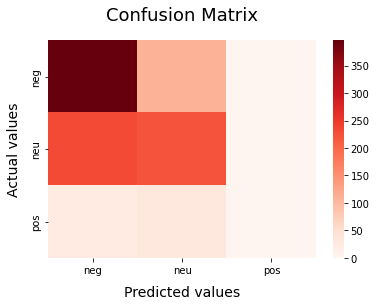

In [ ]:
model_Evaluate(grid_search_MultinomialNB.best_estimator_)

Accuracy of model on training data : 67.93088916982722
Accuracy of model on testing data : 66.56833824975418 

              precision    recall  f1-score   support

         neg       0.71      0.72      0.72       507
         neu       0.62      0.68      0.65       453
         pos       0.00      0.00      0.00        57

    accuracy                           0.67      1017
   macro avg       0.44      0.47      0.46      1017
weighted avg       0.63      0.67      0.65      1017



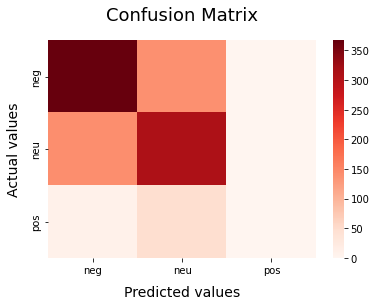

In [ ]:
model_Evaluate(grid_search_LogisticRegression.best_estimator_)

Accuracy of model on training data : 68.52085967130215
Accuracy of model on testing data : 65.5850540806293 

              precision    recall  f1-score   support

         neg       0.70      0.69      0.70       507
         neu       0.61      0.70      0.65       453
         pos       0.00      0.00      0.00        57

    accuracy                           0.66      1017
   macro avg       0.44      0.46      0.45      1017
weighted avg       0.62      0.66      0.64      1017



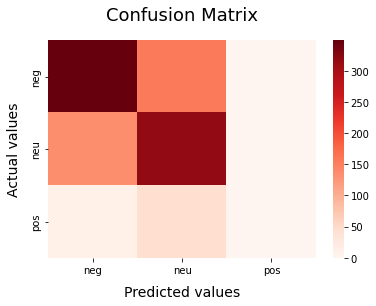

In [ ]:
model_Evaluate(grid_search_LinearSVC.best_estimator_)

Accuracy of model on training data : 78.63463969658659
Accuracy of model on testing data : 69.6165191740413 

              precision    recall  f1-score   support

         neg       0.68      0.84      0.75       507
         neu       0.72      0.62      0.67       453
         pos       0.00      0.00      0.00        57

    accuracy                           0.70      1017
   macro avg       0.47      0.49      0.47      1017
weighted avg       0.66      0.70      0.67      1017



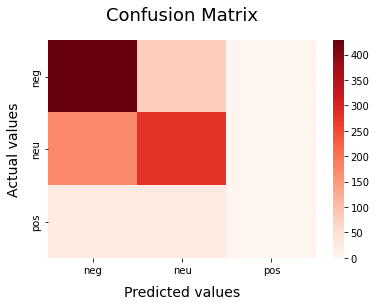

In [ ]:
model_Evaluate(grid_search_RandomForestClassifier)

Accuracy of model on training data : 89.88621997471556
Accuracy of model on testing data : 74.13962635201572 

              precision    recall  f1-score   support

         neg       0.75      0.84      0.80       507
         neu       0.72      0.72      0.72       453
         pos       1.00      0.05      0.10        57

    accuracy                           0.74      1017
   macro avg       0.83      0.54      0.54      1017
weighted avg       0.75      0.74      0.72      1017



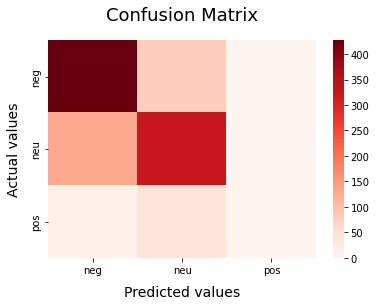

In [ ]:
model_Evaluate(grid_search_BernoulliNB)

Accuracy of model on training data : 65.02317741255794
Accuracy of model on testing data : 65.09341199606686 

              precision    recall  f1-score   support

         neg       0.62      0.86      0.72       507
         neu       0.71      0.49      0.58       453
         pos       0.00      0.00      0.00        57

    accuracy                           0.65      1017
   macro avg       0.45      0.45      0.44      1017
weighted avg       0.63      0.65      0.62      1017



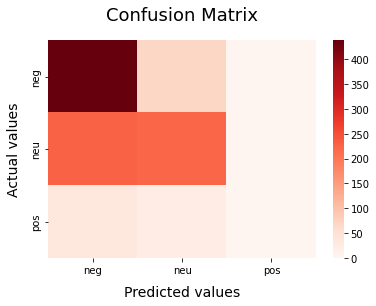

In [ ]:
model_Evaluate(grid_search_DecisionTreeClassifier)